## Histopathological Cancer Detection

In [25]:
# Imports
import os
import cv2
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
from tqdm import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, average_precision_score



In [2]:
TRAIN_DIR = './train'
TEST_DIR = './test'
LABELS_PATH = './train_labels.csv'

In [3]:
# Load Data
labels_df = pd.read_csv(LABELS_PATH)
print(labels_df.shape)
print(labels_df.head())

(220025, 2)
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


## Exploratory Data Analysis

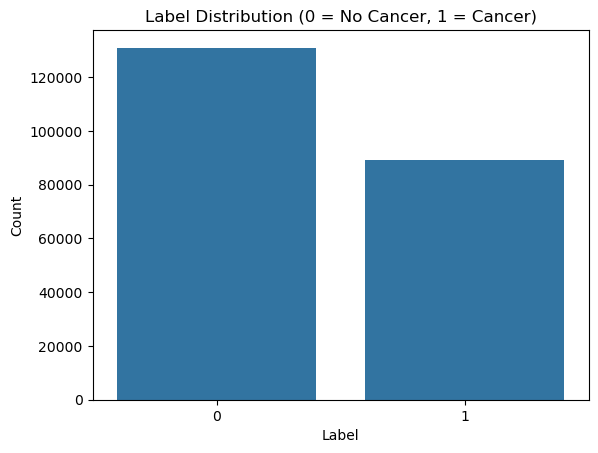

Summary:
Total number of images: 220025
Positive class ratio: 0.4050


In [6]:
sns.countplot(x="label", data=labels_df)
plt.title('Label Distribution (0 = No Cancer, 1 = Cancer)')
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

print("Summary:")
print(f"Total number of images: {len(labels_df)}")
print(f"Positive class ratio: {labels_df['label'].mean():.4f}")

What are doctors looking for:
1. Cellular Morphology (cell shape and structure)
    Doctors examine:
    Nuclear size & shape — cancer cells often have enlarged, irregularly shaped nuclei.
    Hyperchromasia — nuclei appear darker due to increased DNA content.
    Nuclear-to-cytoplasmic ratio — cancer cells have less cytoplasm, more nucleus.
    Pleomorphism — variability in cell and nuclear shapes, indicating abnormal growth.
    🔬 Metastatic cells often lose the uniform appearance of healthy cells.

2. Tissue Architecture Disruption
    Pathologists also assess how organized the tissue looks:
    Normal tissues have clear, regular patterns (e.g. glandular, epithelial).
    In metastasis, this pattern is often disrupted or lost entirely.
    Tumor infiltration breaks normal tissue boundaries, like invading fatty tissue, blood vessels, or lymph nodes.
    Think of metastasis as a loss of local order — like a city map turning into chaotic sprawl.

3. Mitotic Activity
    Cancer cells replicate rapidly.
    Doctors look for mitotic figures — cells caught in the act of dividing (often visible under microscope).
    High mitotic rate suggests malignancy.

4. Staining Patterns (e.g., Hematoxylin and Eosin — H&E)
    Hematoxylin stains nuclei blue/purple (DNA).
    Eosin stains cytoplasm pink (proteins).
    Metastatic tissues may show:
    Densely packed blue nuclei
    Crowded, irregular clusters
    Blurred or broken boundaries between tissue regions
    Your model is learning to mimic this human visual pattern recognition, just statistically.

5. Location of Suspicious Cells
    For metastasis detection, context matters:
    Pathologists check lymph nodes, liver, bone marrow, etc. for the presence of cells from other organs.
    If a breast cancer cell shows up in a lymph node — that’s metastasis.
    They ask:
    “Is this tissue harboring cells that don’t belong here?”

🧬 Optional Confirmations (Beyond Imaging)
Though your project is image-only, real-world diagnosis may also involve:
    Immunohistochemistry (IHC): antibodies that bind to cancer-specific markers
    Molecular tests (e.g. gene expression)
    Patient history + radiology


Cancer Feature	             Normal	                Metastatic Cancer
Cell arrangement	         Ordered, regular	    Disorganized, crowded
Nucleus	                     Small, round	        Large, dark, irregular
Cytoplasm	                 Visible, consistent	Often reduced or distorted
Tissue architecture      	 Maintained	            Disrupted or invaded
Mitoses	                     Few	                Many (active division)



“Pathologists diagnose metastatic cancer by identifying structural abnormalities in cell nuclei, tissue architecture, and cell density in H&E-stained tissue slides. Our model approximates this process by learning to detect such patterns in pixel data — particularly irregular cell clusters and hyperchromatic regions.”


"Hematoxylin and Eosin (H&E) stain visualization shows cellular density (red: nuclei) and tissue stroma (green: cytoplasm). Cancer samples tend to show greater nuclear concentration and disorganized cytoplasmic distribution."

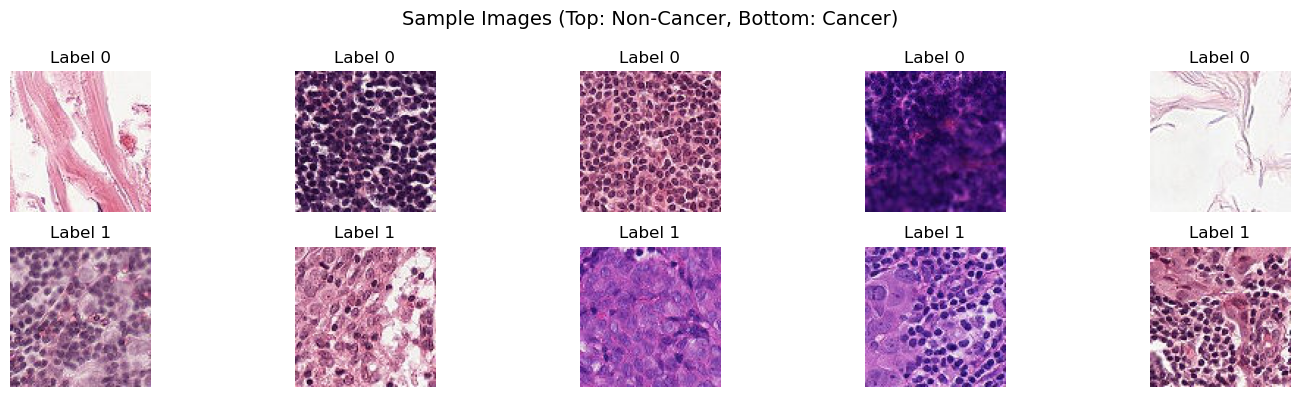

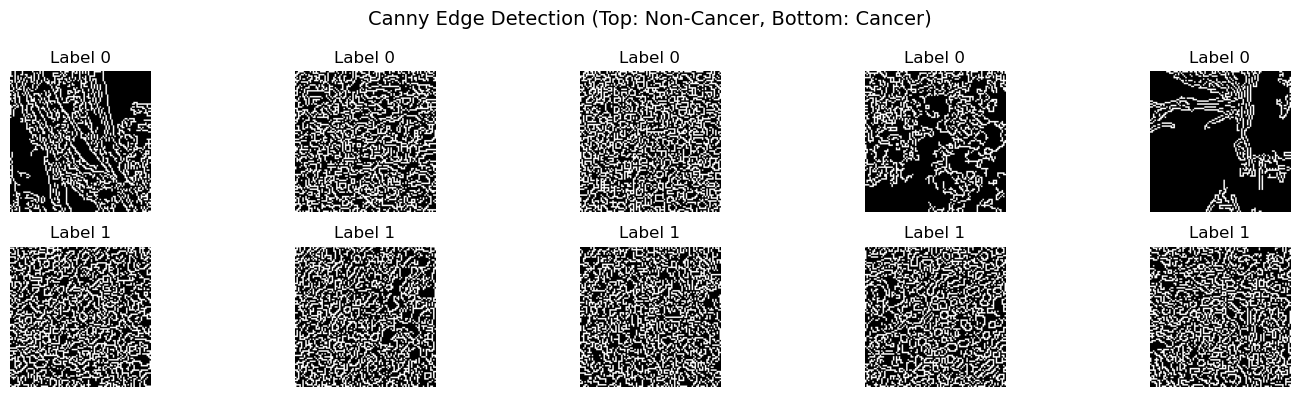

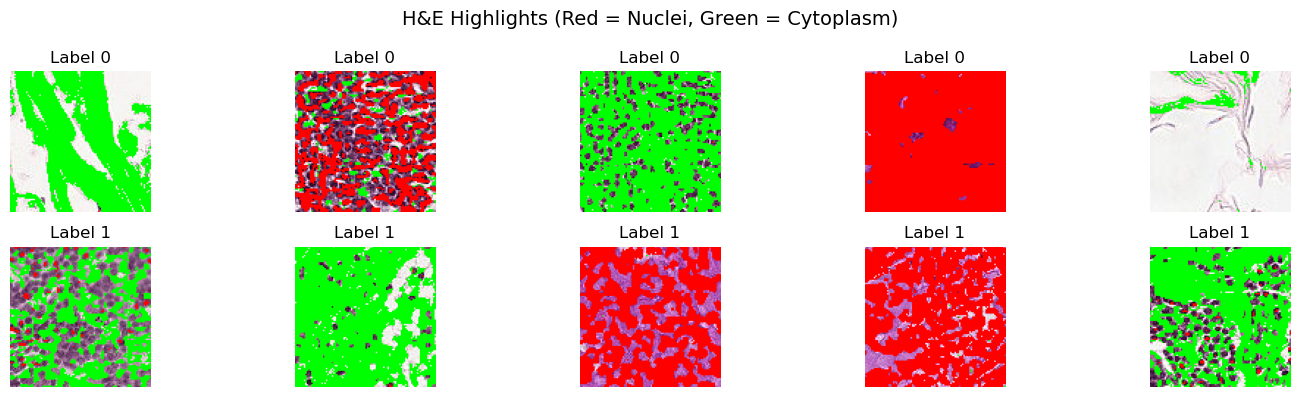

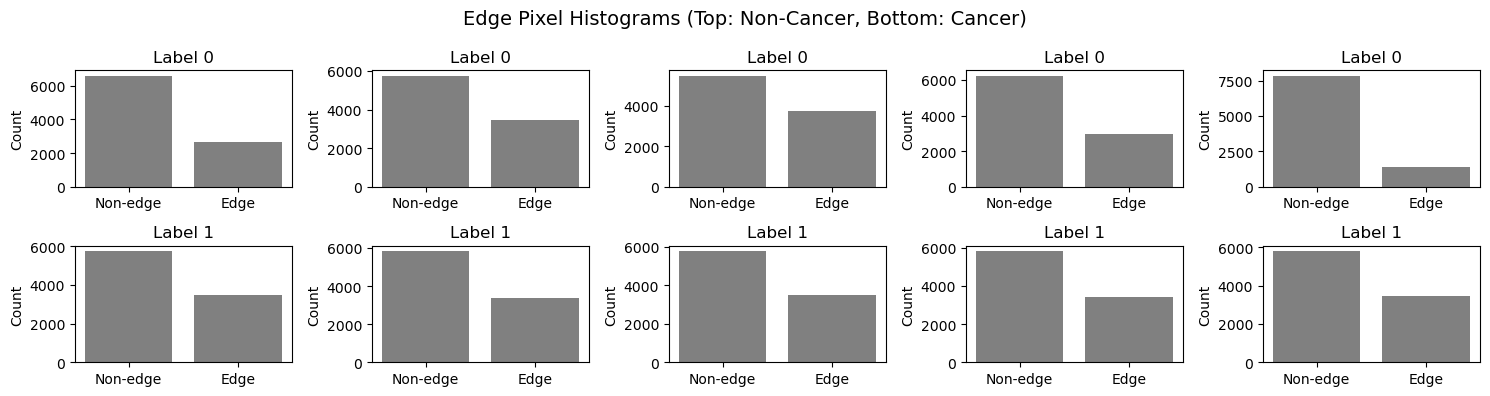

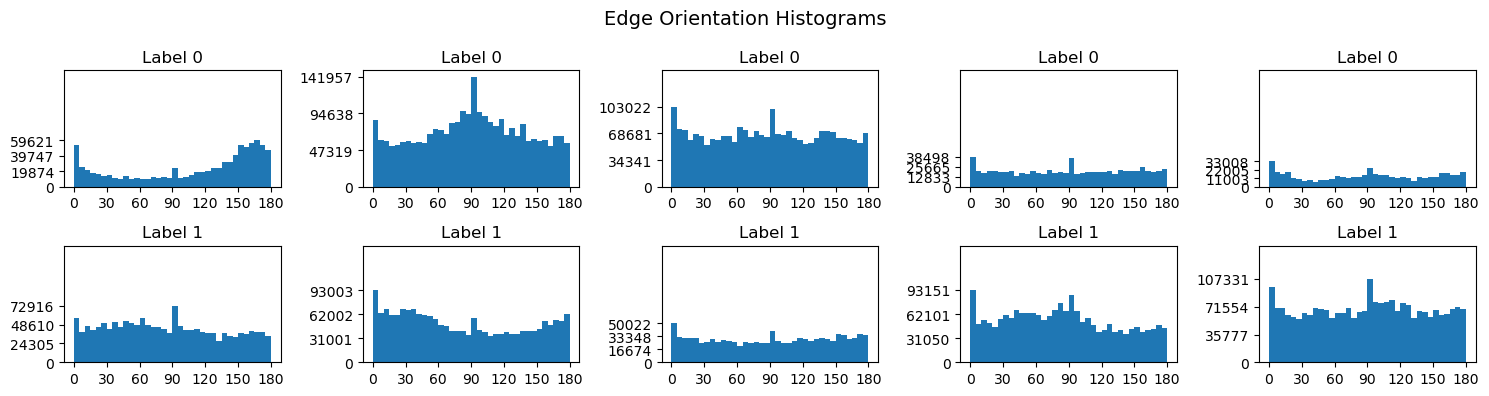

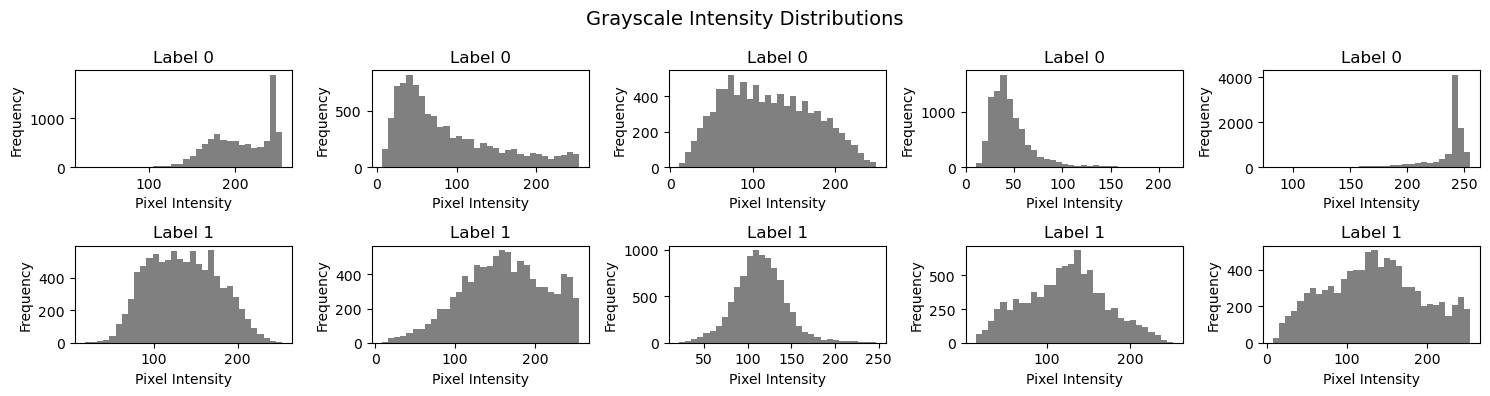

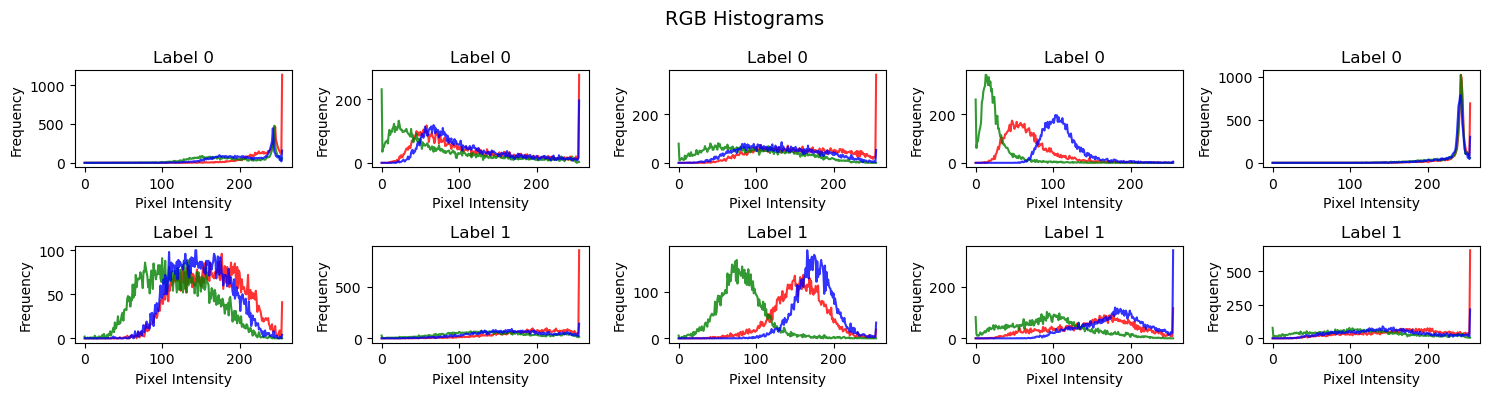

In [7]:
# --- Load Data ---
sample_0 = labels_df[labels_df['label'] == 0].sample(5, random_state=42)
sample_1 = labels_df[labels_df['label'] == 1].sample(5, random_state=42)

def load_image_rgb(img_id):
    path = os.path.join(TRAIN_DIR, img_id + '.tif')
    img = cv2.imread(path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

images_0 = [load_image_rgb(img_id) for img_id in sample_0['id']]
images_1 = [load_image_rgb(img_id) for img_id in sample_1['id']]

# --- 1. Show 5 Non-Cancer and 5 Cancer Images ---
def plot_images(images_0, images_1):
    plt.figure(figsize=(15, 4))
    for i in range(5):
        plt.subplot(2, 5, i+1)
        plt.imshow(images_0[i])
        plt.title("Label 0")
        plt.axis('off')
        plt.subplot(2, 5, i+6)
        plt.imshow(images_1[i])
        plt.title("Label 1")
        plt.axis('off')
    plt.suptitle("Sample Images (Top: Non-Cancer, Bottom: Cancer)", fontsize=14)
    plt.tight_layout()
    plt.show()

# --- 2. Pixel Intensity Distribution (Grayscale Histogram) ---
def plot_grayscale_histograms(images_0, images_1):
    plt.figure(figsize=(15, 4))
    for i in range(5):
        plt.subplot(2, 5, i+1)
        gray = cv2.cvtColor(images_0[i], cv2.COLOR_RGB2GRAY)
        plt.hist(gray.ravel(), bins=32, color='gray')
        plt.title("Label 0")
        plt.xlabel("Pixel Intensity")
        plt.ylabel("Frequency")

        plt.subplot(2, 5, i+6)
        gray = cv2.cvtColor(images_1[i], cv2.COLOR_RGB2GRAY)
        plt.hist(gray.ravel(), bins=32, color='gray')
        plt.title("Label 1")
        plt.xlabel("Pixel Intensity")
        plt.ylabel("Frequency")

    plt.suptitle("Grayscale Intensity Distributions", fontsize=14)
    plt.tight_layout()
    plt.show()

# --- 3. RGB Histograms ---
def plot_rgb_histograms(images_0, images_1):
    plt.figure(figsize=(15, 4))
    for i in range(5):
        plt.subplot(2, 5, i+1)
        for c, color in enumerate(['r', 'g', 'b']):
            hist = cv2.calcHist([images_0[i]], [c], None, [256], [0, 256])
            plt.plot(hist, color=color, alpha=0.8)
        plt.title("Label 0")
        plt.xlabel("Pixel Intensity")
        plt.ylabel("Frequency")

        plt.subplot(2, 5, i+6)
        for c, color in enumerate(['r', 'g', 'b']):
            hist = cv2.calcHist([images_1[i]], [c], None, [256], [0, 256])
            plt.plot(hist, color=color, alpha=0.8)
        plt.title("Label 1")
        plt.xlabel("Pixel Intensity")
        plt.ylabel("Frequency")

    plt.suptitle("RGB Histograms", fontsize=14)
    plt.tight_layout()
    plt.show()

def plot_canny_edges(images_0, images_1, low_thresh=50, high_thresh=150):
    """
    Apply Canny edge detection and show results in 2 rows:
    Top = Non-cancer, Bottom = Cancer
    """
    plt.figure(figsize=(15, 4))

    for i in range(5):
        # Row 1: Non-cancer images
        gray = cv2.cvtColor(images_0[i], cv2.COLOR_RGB2GRAY)
        edges = cv2.Canny(gray, low_thresh, high_thresh)

        plt.subplot(2, 5, i+1)
        plt.imshow(edges, cmap='gray')
        plt.title("Label 0")
        plt.axis('off')
        
        # Row 2: Cancer images
        gray = cv2.cvtColor(images_1[i], cv2.COLOR_RGB2GRAY)
        edges = cv2.Canny(gray, low_thresh, high_thresh)

        plt.subplot(2, 5, i+6)
        plt.imshow(edges, cmap='gray')
        plt.title("Label 1")
        plt.axis('off')

    plt.suptitle("Canny Edge Detection (Top: Non-Cancer, Bottom: Cancer)", fontsize=14)
    plt.tight_layout()
    plt.show()


def plot_canny_edge_pixel_histograms(images_0, images_1, low_thresh=30, high_thresh=100):
    """
    Plot histograms showing count of edge vs non-edge pixels per image using Canny detection.
    """
    plt.figure(figsize=(15, 4))

    for i in range(5):
        # Row 1: Label 0 (non-cancer)
        gray = cv2.cvtColor(images_0[i], cv2.COLOR_RGB2GRAY)
        edges = cv2.Canny(gray, low_thresh, high_thresh)
        non_edge = np.sum(edges == 0)
        edge = np.sum(edges == 255)

        plt.subplot(2, 5, i+1)
        plt.bar(["Non-edge", "Edge"], [non_edge, edge], color='gray')
        plt.title("Label 0")
        plt.ylabel("Count")

        # Row 2: Label 1 (cancer)
        gray = cv2.cvtColor(images_1[i], cv2.COLOR_RGB2GRAY)
        edges = cv2.Canny(gray, low_thresh, high_thresh)
        non_edge = np.sum(edges == 0)
        edge = np.sum(edges == 255)

        plt.subplot(2, 5, i+6)
        plt.bar(["Non-edge", "Edge"], [non_edge, edge], color='gray')
        plt.title("Label 1")
        plt.ylabel("Count")

    plt.suptitle("Edge Pixel Histograms (Top: Non-Cancer, Bottom: Cancer)", fontsize=14)
    plt.tight_layout()
    plt.show()

def highlight_he_stains(image_rgb):
    """
    Highlight nuclei (purple/blue) in red and cytoplasm (pink) in green.
    """
    hsv = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2HSV)

    # Purple/blue mask (nuclei)
    lower_purple = np.array([110, 40, 40])
    upper_purple = np.array([145, 255, 255])

    # Pink mask (cytoplasm)
    lower_pink = np.array([160, 30, 40])
    upper_pink = np.array([179, 255, 255])

    purple_mask = cv2.inRange(hsv, lower_purple, upper_purple)
    pink_mask = cv2.inRange(hsv, lower_pink, upper_pink)

    # Overlay masks
    overlay = image_rgb.copy()
    overlay[purple_mask > 0] = [255, 0, 0]  # Red for nuclei
    overlay[pink_mask > 0] = [0, 255, 0]    # Green for cytoplasm

    return overlay

def plot_he_highlighted_images(images_0, images_1):
    """
    Display H&E-stain-highlighted patches in two rows (label 0 on top, label 1 on bottom).
    """
    plt.figure(figsize=(15, 4))

    for i in range(5):
        highlighted = highlight_he_stains(images_0[i])
        plt.subplot(2, 5, i+1)
        plt.imshow(highlighted)
        plt.title("Label 0")
        plt.axis("off")

        highlighted = highlight_he_stains(images_1[i])
        plt.subplot(2, 5, i+6)
        plt.imshow(highlighted)
        plt.title("Label 1")
        plt.axis("off")

    plt.suptitle("H&E Highlights (Red = Nuclei, Green = Cytoplasm)", fontsize=14)
    plt.tight_layout()
    plt.show()

def compute_edge_orientation_histogram(image_rgb, bins=36, wrap_180=True):
    """
    Compute edge orientation histogram from a grayscale image.
    Args:
        image_rgb: RGB image
        bins: number of bins (e.g. 36 → 5° resolution)
        wrap_180: if True, angles are in [0, 180), otherwise [0, 360)
    Returns:
        hist: normalized histogram
        bin_edges: edges of the histogram bins
    """
    gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
    
    # Compute gradients
    dx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)  # horizontal gradient
    dy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)  # vertical gradient

    # Compute magnitude and orientation
    magnitude = np.sqrt(dx**2 + dy**2)
    angle = np.arctan2(dy, dx) * (180 / np.pi)  # convert to degrees

    # Normalize angle to [0, 360)
    angle = np.mod(angle, 360)

    # If wrapping to [0, 180), fold the angles
    if wrap_180:
        angle = np.mod(angle, 180)

    # Build histogram weighted by edge magnitude
    hist, bin_edges = np.histogram(angle, bins=bins, range=(0, 180 if wrap_180 else 360), weights=magnitude)

    return hist, bin_edges
    
def plot_orientation_histograms_row(images_0, images_1):
    plt.figure(figsize=(15, 4))
    fixed_max_value = 150000
    for i in range(5):
        plt.subplot(2, 5, i+1)
        hist, bins = compute_edge_orientation_histogram(images_0[i])
        plt.bar(0.5*(bins[:-1]+bins[1:]), hist, width=bins[1]-bins[0])
        plt.title("Label 0")
        #plt.xticks([])
        plt.xticks(np.arange(0, 181, 30))
        #plt.yticks([])
        plt.yticks(np.linspace(0, max(hist), 4)) 
        plt.ylim(0, fixed_max_value)

        plt.subplot(2, 5, i+6)
        hist, bins = compute_edge_orientation_histogram(images_1[i])
        plt.bar(0.5*(bins[:-1]+bins[1:]), hist, width=bins[1]-bins[0])
        plt.title("Label 1")
        #plt.xticks([])
        #plt.yticks([])
        plt.xticks(np.arange(0, 181, 30))
        plt.yticks(np.linspace(0, max(hist), 4)) 
        plt.ylim(0, fixed_max_value)

    plt.suptitle("Edge Orientation Histograms", fontsize=14)
    plt.tight_layout()
    plt.show()


# --- Run All ---
plot_images(images_0, images_1)
plot_canny_edges(images_0, images_1)
plot_he_highlighted_images(images_0, images_1)
plot_canny_edge_pixel_histograms(images_0, images_1)
plot_orientation_histograms_row(images_0, images_1)
plot_grayscale_histograms(images_0, images_1)
plot_rgb_histograms(images_0, images_1)


## Prepare Data

In [8]:
# Dataset Class
class CancerDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_id = self.dataframe.iloc[idx]['id']
        img_path = os.path.join(self.img_dir, img_id + '.tif')
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image)

        if 'label' in self.dataframe.columns:
            label = self.dataframe.iloc[idx]['label']
            return image, label
        else:
            return image, img_id

In [19]:
# Training Transforms
BATCH_SIZE = 32
IMG_SIZE = 96

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.ToTensor()
])


# Validation Transforms
val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

In [20]:
# Get Subset of Training Labels
subset_labels = labels_df.sample(frac=0.2, random_state=42)
train_df, val_df = train_test_split(subset_labels, test_size=0.2, stratify=subset_labels['label'], random_state=42)

In [21]:
# List pretrained models
#models.list_models(module=models)

In [22]:
# Transform and Load Dataset
train_dataset = CancerDataset(train_df, TRAIN_DIR, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

val_dataset = CancerDataset(val_df, TRAIN_DIR, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

## Configure Model

In [23]:
#-- Config ---
NUM_EPOCHS = 10
LEARNING_RATE = 1e-3
# Run on M2
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cpu")
print(f"Using device: {DEVICE}")

Using device: mps


In [32]:
# Configure Functions
def load_resnet_model():
    model = models.resnet18(pretrained=True) # load resent
    model.fc = nn.Linear(model.fc.in_features,1) #convert to binary output
    model = model.to(DEVICE) #run on m2
    return model


def configure_resnet(model):
    criterion = nn.BCEWithLogitsLoss()
    #optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", patience=2, factor=0.5)
    return criterion, optimizer, scheduler


model = load_resnet_model()
criterion, optimizer, scheduler = configure_resnet(model)

/opt/anaconda3/envs/hw5_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/hw5_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [27]:
# Training Loop
best_auc = 0 # Track best performance

# Loop Epoch
for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0.0

    # Run Training Calculate Loss
    for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        images = images.to(DEVICE)
        labels = labels.float().unsqueeze(1).to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Run Validation For Each Epoch
    model.eval()
    all_labels = []
    all_outputs = []

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}"):
            images = images.to(DEVICE)
            labels = labels.float().unsqueeze(1).to(DEVICE)

            outputs = model(images)
            outputs = torch.sigmoid(outputs)

            all_labels.append(labels.cpu().numpy())
            all_outputs.append(outputs.cpu().numpy())

    # Calculate Metrics
    all_labels = np.vstack(all_labels)
    all_outputs = np.vstack(all_outputs)

    probs = np.vstack(all_outputs)
    labels = np.vstack(all_labels)
    preds = (probs > 0.5).astype(int)
    
    metrics = {
        "ROC-AUC": roc_auc_score(labels, probs),
        "PR-AUC": average_precision_score(labels, probs),
        "Accuracy": accuracy_score(labels, preds),
        "Precision": precision_score(labels, preds),
        "Recall": recall_score(labels, preds),
        "F1 Score": f1_score(labels, preds)
    }
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] - Train Loss: {train_loss:.4f}, Val AUC: {metrics['ROC-AUC']:.4f}, Accuracy: {metrics['Accuracy']:.4f}, F1: {metrics['F1 Score']:.4f}")

    val_auc = metrics["ROC-AUC"]
    scheduler.step(val_auc)

    # Save best model
    if val_auc > best_auc:
        best_auc = val_auc
        torch.save(model.state_dict(), 'best_model.pth')

print(f"Best Validation ROC-AUC: {best_auc:.4f}")


Validation Epoch 1: 100%|█████████████████████| 276/276 [00:05<00:00, 46.94it/s]


Epoch [1/10] - Train Loss: 0.3623, Val AUC: 0.9439, Accuracy: 0.8459, F1: 0.7743


Validation Epoch 2: 100%|█████████████████████| 276/276 [00:05<00:00, 47.83it/s]


Epoch [2/10] - Train Loss: 0.3034, Val AUC: 0.9290, Accuracy: 0.7689, F1: 0.6027


Validation Epoch 3: 100%|█████████████████████| 276/276 [00:05<00:00, 48.15it/s]


Epoch [3/10] - Train Loss: 0.2855, Val AUC: 0.9478, Accuracy: 0.8223, F1: 0.8131


Validation Epoch 4: 100%|█████████████████████| 276/276 [00:05<00:00, 47.66it/s]


Epoch [4/10] - Train Loss: 0.2691, Val AUC: 0.8803, Accuracy: 0.7283, F1: 0.5040


Validation Epoch 5: 100%|█████████████████████| 276/276 [00:05<00:00, 48.28it/s]


Epoch [5/10] - Train Loss: 0.2522, Val AUC: 0.9499, Accuracy: 0.8760, F1: 0.8527


Validation Epoch 6: 100%|█████████████████████| 276/276 [00:05<00:00, 47.92it/s]


Epoch [6/10] - Train Loss: 0.2428, Val AUC: 0.9292, Accuracy: 0.8562, F1: 0.8134


Validation Epoch 7: 100%|█████████████████████| 276/276 [00:05<00:00, 47.87it/s]


Epoch [7/10] - Train Loss: 0.2327, Val AUC: 0.9580, Accuracy: 0.8867, F1: 0.8460


Validation Epoch 8: 100%|█████████████████████| 276/276 [00:05<00:00, 48.42it/s]


Epoch [8/10] - Train Loss: 0.2247, Val AUC: 0.9606, Accuracy: 0.8106, F1: 0.7001


Validation Epoch 9: 100%|█████████████████████| 276/276 [00:05<00:00, 48.04it/s]


Epoch [9/10] - Train Loss: 0.2184, Val AUC: 0.9621, Accuracy: 0.8880, F1: 0.8688


Validation Epoch 10: 100%|████████████████████| 276/276 [00:05<00:00, 47.32it/s]


Epoch [10/10] - Train Loss: 0.2150, Val AUC: 0.9651, Accuracy: 0.8996, F1: 0.8802
Best Validation ROC-AUC: 0.9651


In [28]:
# Evaluate Best Model
SUBMISSION_PATH = './submission.csv'

# Load Model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Load Test Data
test_filenames = [f.split('.')[0] for f in os.listdir(TEST_DIR)]
test_df = pd.DataFrame({'id': test_filenames})
test_dataset = CancerDataset(test_df, TEST_DIR, transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# Generate Predictions
all_ids = []
all_preds = []

with torch.no_grad():
    for images, ids in tqdm(test_loader, desc="Predicting on test set"):
        images = images.to(DEVICE)
        outputs = model(images)
        outputs = torch.sigmoid(outputs)
        preds = outputs.cpu().numpy().flatten()

        all_ids.extend(ids)
        all_preds.extend(preds)


# Create Submissions
submission_df = pd.DataFrame({
    'id': all_ids,
    'label': all_preds
})
submission_df.to_csv(SUBMISSION_PATH, index=False)


/var/folders/r_/py09c5td51nb44wpqy1424_w0000gn/T/ipykernel_68765/1169875551.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.

## SGD Optimizer

In [33]:
# Training Loop
best_auc = 0 # Track best performance

# Loop Epoch
for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0.0

    # Run Training Calculate Loss
    for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        images = images.to(DEVICE)
        labels = labels.float().unsqueeze(1).to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Run Validation For Each Epoch
    model.eval()
    all_labels = []
    all_outputs = []

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}"):
            images = images.to(DEVICE)
            labels = labels.float().unsqueeze(1).to(DEVICE)

            outputs = model(images)
            outputs = torch.sigmoid(outputs)

            all_labels.append(labels.cpu().numpy())
            all_outputs.append(outputs.cpu().numpy())

    # Calculate Metrics
    all_labels = np.vstack(all_labels)
    all_outputs = np.vstack(all_outputs)

    probs = np.vstack(all_outputs)
    labels = np.vstack(all_labels)
    preds = (probs > 0.5).astype(int)
    
    metrics = {
        "ROC-AUC": roc_auc_score(labels, probs),
        "PR-AUC": average_precision_score(labels, probs),
        "Accuracy": accuracy_score(labels, preds),
        "Precision": precision_score(labels, preds),
        "Recall": recall_score(labels, preds),
        "F1 Score": f1_score(labels, preds)
    }
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] - Train Loss: {train_loss:.4f}, Val AUC: {metrics['ROC-AUC']:.4f}, Accuracy: {metrics['Accuracy']:.4f}, F1: {metrics['F1 Score']:.4f}")

    val_auc = metrics["ROC-AUC"]
    scheduler.step(val_auc)

    # Save best model
    if val_auc > best_auc:
        best_auc = val_auc
        torch.save(model.state_dict(), 'best_model.pth')

print(f"Best Validation ROC-AUC: {best_auc:.4f}")

Validation Epoch 1: 100%|█████████████████████| 276/276 [00:05<00:00, 47.29it/s]


Epoch [1/10] - Train Loss: 0.3396, Val AUC: 0.9565, Accuracy: 0.8938, F1: 0.8626


Validation Epoch 2: 100%|█████████████████████| 276/276 [00:05<00:00, 47.14it/s]


Epoch [2/10] - Train Loss: 0.2651, Val AUC: 0.9704, Accuracy: 0.9169, F1: 0.8984


Validation Epoch 3: 100%|█████████████████████| 276/276 [00:05<00:00, 47.64it/s]


Epoch [3/10] - Train Loss: 0.2435, Val AUC: 0.9712, Accuracy: 0.9218, F1: 0.9028


Validation Epoch 4: 100%|█████████████████████| 276/276 [00:05<00:00, 48.09it/s]


Epoch [4/10] - Train Loss: 0.2229, Val AUC: 0.9734, Accuracy: 0.9158, F1: 0.8886


Validation Epoch 5: 100%|█████████████████████| 276/276 [00:05<00:00, 48.13it/s]


Epoch [5/10] - Train Loss: 0.2135, Val AUC: 0.9789, Accuracy: 0.9351, F1: 0.9174


Validation Epoch 6: 100%|█████████████████████| 276/276 [00:05<00:00, 47.54it/s]


Epoch [6/10] - Train Loss: 0.2016, Val AUC: 0.9785, Accuracy: 0.9305, F1: 0.9096


Validation Epoch 7: 100%|█████████████████████| 276/276 [00:05<00:00, 47.99it/s]


Epoch [7/10] - Train Loss: 0.1973, Val AUC: 0.9804, Accuracy: 0.9277, F1: 0.9051


Validation Epoch 8: 100%|█████████████████████| 276/276 [00:05<00:00, 48.00it/s]


Epoch [8/10] - Train Loss: 0.1886, Val AUC: 0.9802, Accuracy: 0.9350, F1: 0.9179


Validation Epoch 9: 100%|█████████████████████| 276/276 [00:05<00:00, 47.98it/s]


Epoch [9/10] - Train Loss: 0.1791, Val AUC: 0.9824, Accuracy: 0.9350, F1: 0.9158


Validation Epoch 10: 100%|████████████████████| 276/276 [00:05<00:00, 48.78it/s]


Epoch [10/10] - Train Loss: 0.1716, Val AUC: 0.9817, Accuracy: 0.9363, F1: 0.9192
Best Validation ROC-AUC: 0.9824
